# Logistic Regression using Scikit-Learn

### Data preparation

In [2]:
# Importing libraries

from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np

import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

print("All libs imported.")

In [3]:
# Downloading the compressed notMNIST dataset

import os
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = './data' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./src/notMNIST_large.tar.gz
Found and verified ./src/notMNIST_small.tar.gz


In [4]:
# Extracting the dataset from the .tar files

num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./src/notMNIST_large already present - Skipping extraction of ./src/notMNIST_large.tar.gz.
['./src/notMNIST_large/A', './src/notMNIST_large/B', './src/notMNIST_large/C', './src/notMNIST_large/D', './src/notMNIST_large/E', './src/notMNIST_large/F', './src/notMNIST_large/G', './src/notMNIST_large/H', './src/notMNIST_large/I', './src/notMNIST_large/J']
./src/notMNIST_small already present - Skipping extraction of ./src/notMNIST_small.tar.gz.
['./src/notMNIST_small/A', './src/notMNIST_small/B', './src/notMNIST_small/C', './src/notMNIST_small/D', './src/notMNIST_small/E', './src/notMNIST_small/F', './src/notMNIST_small/G', './src/notMNIST_small/H', './src/notMNIST_small/I', './src/notMNIST_small/J']


In [5]:
# Checking if image can be properly displayed from the data 

Image(filename = "./data/notMNIST_large/A/a2VhZ2FuLnR0Zg==.png")

In [6]:
# Pickling the dataset into files for each letter in each 'case'

image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./src/notMNIST_large/A.pickle already present - Skipping pickling.
./src/notMNIST_large/B.pickle already present - Skipping pickling.
./src/notMNIST_large/C.pickle already present - Skipping pickling.
./src/notMNIST_large/D.pickle already present - Skipping pickling.
./src/notMNIST_large/E.pickle already present - Skipping pickling.
./src/notMNIST_large/F.pickle already present - Skipping pickling.
./src/notMNIST_large/G.pickle already present - Skipping pickling.
./src/notMNIST_large/H.pickle already present - Skipping pickling.
./src/notMNIST_large/I.pickle already present - Skipping pickling.
./src/notMNIST_large/J.pickle already present - Skipping pickling.
./src/notMNIST_small/A.pickle already present - Skipping pickling.
./src/notMNIST_small/B.pickle already present - Skipping pickling.
./src/notMNIST_small/C.pickle already present - Skipping pickling.
./src/notMNIST_small/D.pickle already present - Skipping pickling.
./src/notMNIST_small/E.pickle already present - Skipping pickl

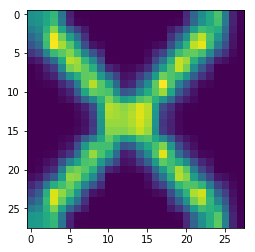

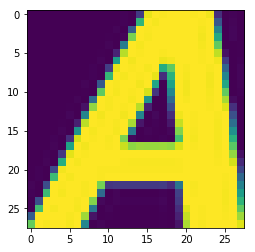

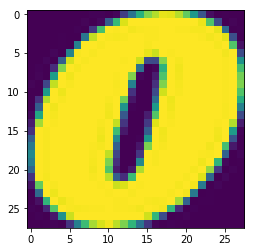

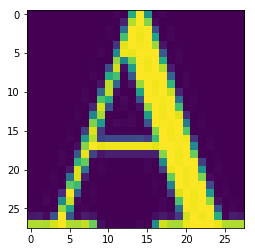

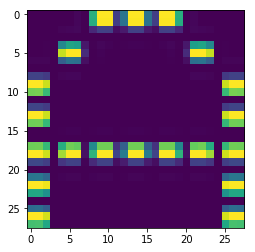

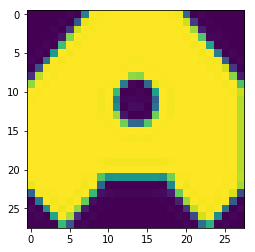

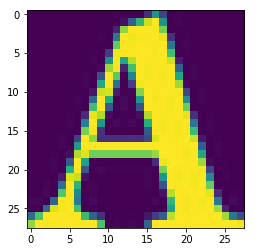

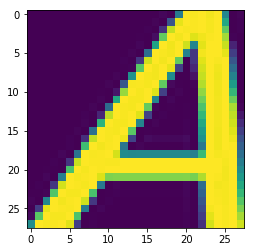

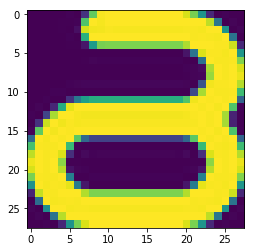

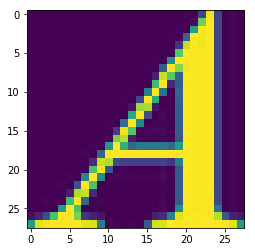

In [7]:
# Checking if the data can still be displayed

fig = pickle.load(open('./data/notMNIST_large/A.pickle',  'rb')  )

# from PIL import Image as Img
# img = Img.fromarray(np.uint8(figx[1] * 255) , 'L')
# #img = Img.fromarray(figx[1], 'L')
# img.show()

# Display matrix
for i in range(10):
    #plt.matshow(fig[i])
    plt.imshow(fig[i])
    plt.show()

In [8]:
# Merging all character data to create seperate dataset for training, validation, testing

def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [9]:
# Shuffling datasets for better performance

def  randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

Few training images:

	Label:  4


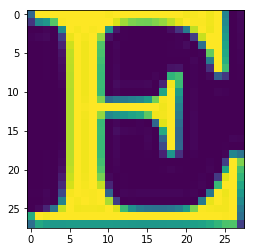

	Label:  2


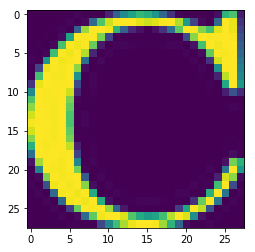

	Label:  7


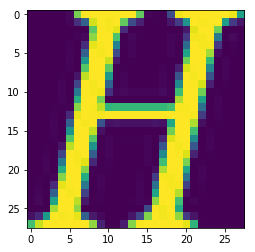

	Label:  9


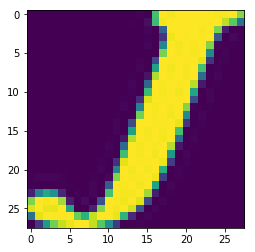

	Label:  4


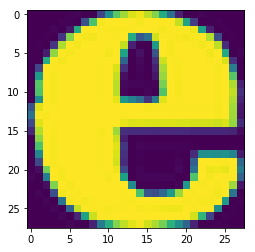

	Label:  9


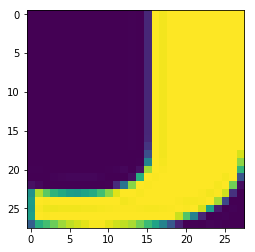

	Label:  2


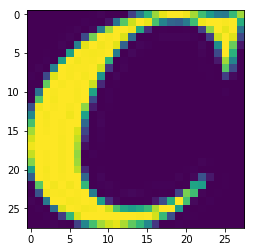

	Label:  6


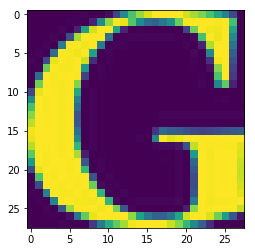

	Label:  9


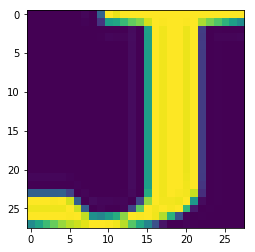

	Label:  2


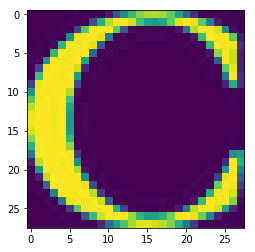

Few Testing images:

	Label:  3


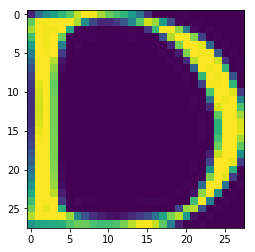

	Label:  3


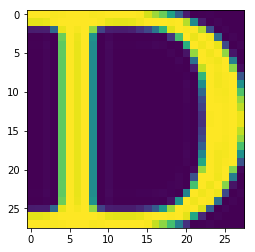

	Label:  9


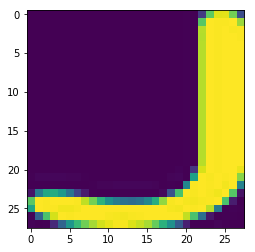

	Label:  7


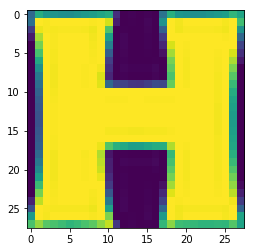

	Label:  4


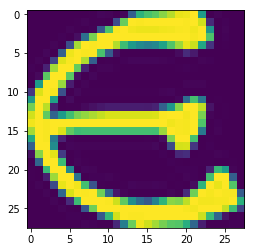

	Label:  3


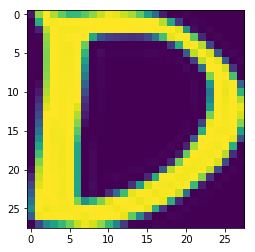

	Label:  6


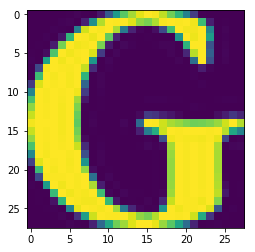

	Label:  0


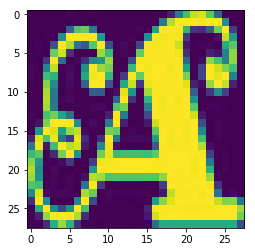

	Label:  7


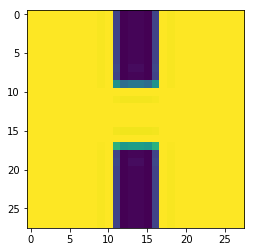

	Label:  8


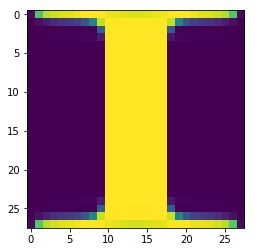

Few Validation images:

	Label:  1


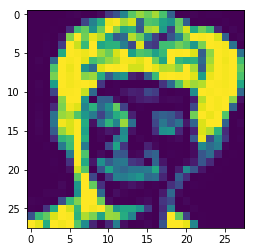

	Label:  9


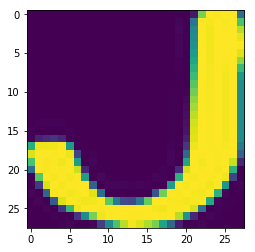

	Label:  8


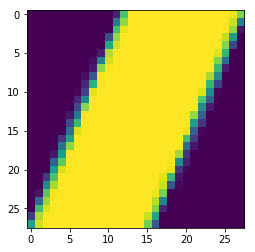

	Label:  4


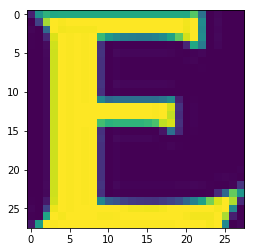

	Label:  7


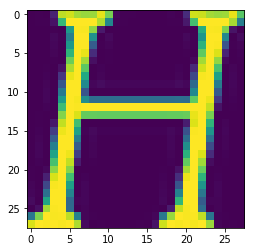

	Label:  0


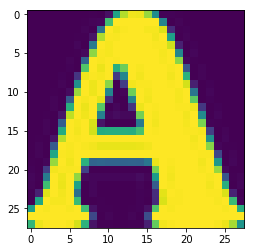

	Label:  2


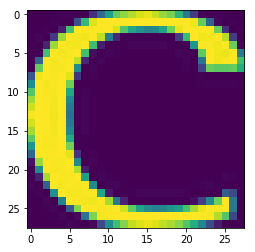

	Label:  6


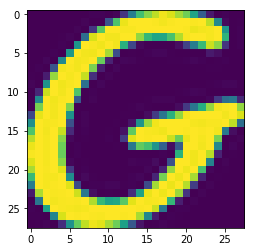

	Label:  8


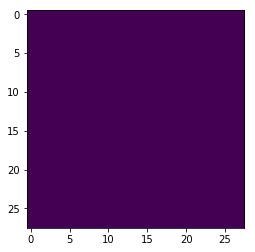

	Label:  4


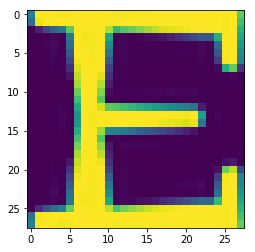

In [10]:
# Checking if the data still makes sense

print("Few training images:\n")
for i in range(10):
    print("\tLabel: ", train_labels[i*5000])
    plt.imshow(train_dataset[i*5000])
    plt.show()
    
print("Few Testing images:\n")
for i in range(10):
    print("\tLabel: ", test_labels[i*500])
    plt.imshow(test_dataset[i*500])
    plt.show()

print("Few Validation images:\n")
for i in range(10):
    print("\tLabel: ", valid_labels[i*500])
    plt.imshow(valid_dataset[i*500])
    plt.show()

In [11]:
#Pickling the datasets for further requirements

pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

#### Finding overlaps between train, test and valid datasets

In [24]:
# Hashing the datasets to compare them

from collections import defaultdict

def calchash(img):
    s = 0
    for row in img:
        for pix in row:
            s += pix**2
    return s

train_hashes = set()
test_hashes = set()
valid_hashes = set()

train_map = dict()
train_imap = defaultdict(list)

test_map = dict()
test_imap = defaultdict(list)

valid_map = dict()
valid_imap = defaultdict(list)

print('Calculating hashes of train')
for i in range(len(train_labels)):
    h = calchash(train_dataset[i])
    train_map[i] = h
    train_imap[h].append(i)
    train_hashes.add(h)
    if i%2000 == 0:
        print('.', end = '')
        
print('\nCalculating hashes of test')
for i in range(len(test_labels)):
    h = calchash(test_dataset[i])
    test_map[i] = h
    test_imap[h].append(i)
    test_hashes.add(h)
    if i%100 == 0:
        print('.', end='')


print('\nCalculating hashes of valid')
for i in range(len(valid_labels)):
    h = calchash(valid_dataset[i])
    valid_map[i] = h
    valid_imap[h].append(i)
    valid_hashes.add(h)
    if i%100 == 0:
        print('.', end='')

#np.array_equal(A,B)  # test if same shape, same elements values
#np.array_equiv(A,B)  # test if broadcastable shape, same elements values
#np.allclose(A,B,...) # test if same shape, elements have close enough values
            

Calculating hashes of train
....................................................................................................
Calculating hashes of test
....................................................................................................
Calculating hashes of valid
....................................................................................................

In [22]:
# Finding out overlaps from the hashes

repeated_in_test = set()      #stores training and testing overlaps
repeated_in_valid = set()     #stores training and validtion overlaps
repeated_test_valid = set()   #stores testing and validation overlaps

for i in train_map:
    if train_map[i] in test_hashes:
        #print(i,"th train image has same hash as following test images:",
             # ",".join(map(str, test_imap[train_map[i]]))
        for j in test_imap[train_map[i]]:
            if np.array_equal(train_dataset[i], test_dataset[j]):
                #print('same image', j)
                repeated_in_test.add(j)

for i in train_map:
    if train_map[i] in valid_hashes:
        for j in valid_imap[train_map[i]]:
            if np.array_equal(train_dataset[i], valid_dataset[j]):
                repeated_in_valid.add(j)

for i in test_map:
    if test_map[i] in valid_hashes:
        for j in valid_imap[test_map[i]]:
            if np.array_equal(test_dataset[i], valid_dataset[j]):
                repeated_test_valid.add(j)
                

print('Training and Testing overlaps: ', len(repeated_in_test))
print('Training and Validtion overlaps: ', len(repeated_in_valid))
print('Testing and Validation overlaps: ', len(repeated_test_valid))


Training and Testing overlaps:  1317
Training and Validtion overlaps:  1085
Testing and Validation overlaps:  185


### Running Logistic Regression from the final datasets using Scikit-Learn

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

data = pickle.load( open( ".data/notMNIST.pickle", "rb" ) )

print("Loading data...")

train_data = data['train_dataset']
train_label = data['train_labels']

test_data = data['test_dataset']
test_label = data['test_labels']

valid_data = data['valid_dataset']
valid_label = data['valid_labels']

#print("Dimensions of training dataset before compressing each image:",train_data.shape)
#Compressing each image in a single array
train_data = train_data.reshape(200000, 784)
test_data = test_data.reshape(10000, 784)
valid_data = valid_data.reshape(10000, 784)
#print("Dimensions of training dataset after compressing each image:", train_data.shape)


print("\n\n\nTraining model using 50 images")

classifier1 = LogisticRegression(verbose=1, n_jobs=-1,solver='sag', max_iter=200)
print("\nStarting fitting...")
classifier1.fit(train_data[:50], train_labels[:50])
print("\nModel trained on 50 images!")

print("\n\nMean accuracy on Validation Dataset = ", classifier1.score(valid_data[:25], valid_label[:25]),"\n")
predicted_label = classifier1.predict(valid_data[:25])
print("\nOther evaluations on Validation Dataset: \n", metrics.classification_report(valid_label[:25], predicted_label, target_names=['A','B','C','D','E','F','G','H','I','J']))

print("\n\nMean accuracy on Test Dataset = ", classifier1.score(test_data[:25], test_label[:25]),"\n")
predicted_label = classifier1.predict(test_data[:25])
print("\nOther evaluations on Test Dataset: \n", metrics.classification_report(test_label[:25], predicted_label, target_names=['A','B','C','D','E','F','G','H','I','J']))




print("\n\n\nTraining model using 100 images")

classifier2 = LogisticRegression(verbose=1, n_jobs=-1,solver='sag', max_iter=200)
print("\nStarting fitting...")
classifier2.fit(train_data[:100], train_labels[:100])
print("\nModel trained on 100 images!")

print("\n\nMean accuracy on Validation Dataset = ", classifier2.score(valid_data[:50], valid_label[:50]),"\n")
predicted_label = classifier2.predict(valid_data[:50])
print("\nOther evaluations on Validation Dataset: \n", metrics.classification_report(valid_label[:50], predicted_label, target_names=['A','B','C','D','E','F','G','H','I','J']))

print("\n\nMean accuracy on Test Dataset = ", classifier2.score(test_data[:50], test_label[:50]),"\n")
predicted_label = classifier2.predict(test_data[:50])
print("\nOther evaluations on Test Dataset: \n", metrics.classification_report(test_label[:50], predicted_label, target_names=['A','B','C','D','E','F','G','H','I','J']))




print("\n\n\nTraining model using 1000 images")

classifier3 = LogisticRegression(verbose=1, n_jobs=-1,solver='sag', max_iter=200)
print("\nStarting fitting...")
classifier3.fit(train_data[:1000], train_labels[:1000])
print("\nModel trained on 1000 images!")

print("\n\nMean accuracy on Validation Dataset = ", classifier3.score(valid_data[:500], valid_label[:500]),"\n")
predicted_label = classifier3.predict(valid_data[:500])
print("\nOther evaluations on Validation Dataset: \n", metrics.classification_report(valid_label[:500], predicted_label, target_names=['A','B','C','D','E','F','G','H','I','J']))

print("\n\nMean accuracy on Test Dataset = ", classifier3.score(test_data[:500], test_label[:500]),"\n")
predicted_label = classifier3.predict(test_data[:500])
print("\nOther evaluations on Test Dataset: \n", metrics.classification_report(test_label[:500], predicted_label, target_names=['A','B','C','D','E','F','G','H','I','J']))




print("\n\n\nTraining model using 5000 images")

classifier4 = LogisticRegression(verbose=1, n_jobs=-1,solver='sag', max_iter=200)
print("\nStarting fitting...")
classifier4.fit(train_data[:5000], train_labels[:5000])
print("\nModel trained on 5000 images!")

print("\nMean accuracy on Validation Dataset = ", classifier4.score(valid_data[:2500], valid_label[:2500]),"\n")
predicted_label = classifier4.predict(valid_data[:2500])
print("\nOther evaluations on Validation Dataset: \n", metrics.classification_report(valid_label[:2500], predicted_label, target_names=['A','B','C','D','E','F','G','H','I','J']))

print("\n\nMean accuracy on Test Dataset = ", classifier4.score(test_data[:2500], test_label[:2500]),"\n")
predicted_label = classifier4.predict(test_data[:2500])
print("\nOther evaluations on Test Dataset: \n", metrics.classification_report(test_label[:2500], predicted_label, target_names=['A','B','C','D','E','F','G','H','I','J']))




print("\n\n\nTraining model using 200000 images")

classifier5 = LogisticRegression(verbose=1, n_jobs=-1,solver='sag', max_iter=200)
print("\nStarting fitting...")
classifier5.fit(train_data, train_labels)
print("\nModel trained on 5000 images!")

print("\nMean accuracy on Validation Dataset = ", classifier5.score(valid_data, valid_label),"\n")
predicted_label = classifier5.predict(valid_data)
print("\nOther evaluations on Validation Dataset: \n", metrics.classification_report(valid_label, predicted_label, target_names=['A','B','C','D','E','F','G','H','I','J']))

print("\n\nMean accuracy on Test Dataset = ", classifier5.score(test_data, test_label),"\n")
predicted_label = classifier5.predict(test_data)
print("\nOther evaluations on Test Dataset: \n", metrics.classification_report(test_label, predicted_label, target_names=['A','B','C','D','E','F','G','H','I','J']))



Loading data...



Training model using 50 images

Starting fitting...
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds


/home/adishree/Desktop/udact/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 1 seconds
max_iter reached after 1 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds

Model trained on 50 images!


Mean accuracy on Validation Dataset =  0.4 


Other evaluations on Validation Dataset: 
              precision    recall  f1-score   support

          A       0.50      0.50      0.50         2
          B       0.17      0.33      0.22         3
          C       0.50      0.33      0.40         3
          D       0.50      0.33      0.40         3
          E       0.00      0.00      0.00         4
          F       0.00      0.00      0.00         0
          G       0.00      0.00      0.00         1
          H       1.00      0.33      0.50         3
          I       0.50      0.50      0.50         2
          J       0.80      1.00      0.89         4

avg / total       0.47      0.40      0.40        25



[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.7s finished
/home/adishree/Desktop/udact/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/adishree/Desktop/udact/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)




Mean accuracy on Test Dataset =  0.72 


Other evaluations on Test Dataset: 
              precision    recall  f1-score   support

          A       1.00      0.33      0.50         3
          B       0.50      1.00      0.67         1
          C       1.00      0.67      0.80         3
          D       1.00      1.00      1.00         1
          E       0.50      0.50      0.50         2
          F       0.00      0.00      0.00         1
          G       0.60      1.00      0.75         3
          H       0.80      0.67      0.73         6
          I       0.75      1.00      0.86         3
          J       0.67      1.00      0.80         2

avg / total       0.75      0.72      0.69        25




Training model using 100 images

Starting fitting...
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 1 seconds
max_iter reached after 1 se

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s finished


0.74 


Other evaluations on Test Dataset: 
              precision    recall  f1-score   support

          A       1.00      0.40      0.57         5
          B       0.75      0.50      0.60         6
          C       0.73      0.89      0.80         9
          D       0.83      1.00      0.91         5
          E       0.50      0.50      0.50         2
          F       0.50      0.50      0.50         2
          G       0.75      0.60      0.67         5
          H       0.86      0.75      0.80         8
          I       0.83      1.00      0.91         5
          J       0.50      1.00      0.67         3

avg / total       0.77      0.74      0.73        50




Training model using 1000 images

Starting fitting...
max_iter reached after 5 seconds
max_iter reached after 5 seconds
max_iter reached after 5 seconds
max_iter reached after 5 seconds
max_iter reached after 5 seconds
max_iter reached after 5 seconds
max_iter reached after 5 seconds
max_iter reached after 5 sec

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.1s finished


convergence after 185 epochs took 22 seconds
convergence after 187 epochs took 23 seconds
max_iter reached after 24 seconds
convergence after 198 epochs took 24 seconds
convergence after 197 epochs took 25 seconds
max_iter reached after 24 seconds
convergence after 196 epochs took 24 seconds
convergence after 198 epochs took 24 seconds
convergence after 182 epochs took 13 seconds
convergence after 188 epochs took 13 seconds

Model trained on 5000 images!

Mean accuracy on Validation Dataset =  0.7752 


Other evaluations on Validation Dataset: 
              precision    recall  f1-score   support

          A       0.79      0.76      0.77       210
          B       0.81      0.74      0.78       247
          C       0.75      0.79      0.77       239
          D       0.77      0.84      0.80       243
          E       0.75      0.73      0.74       257
          F       0.80      0.82      0.81       247
          G       0.78      0.75      0.76       241
          H       0.80 

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.0min finished


convergence after 51 epochs took 240 seconds
convergence after 58 epochs took 271 seconds
convergence after 58 epochs took 271 seconds
convergence after 77 epochs took 353 seconds
convergence after 58 epochs took 251 seconds
convergence after 52 epochs took 225 seconds
convergence after 53 epochs took 228 seconds
convergence after 86 epochs took 355 seconds
convergence after 64 epochs took 199 seconds
convergence after 67 epochs took 205 seconds


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 11.7min finished



Model trained on 5000 images!

Mean accuracy on Validation Dataset =  0.8215 


Other evaluations on Validation Dataset: 
              precision    recall  f1-score   support

          A       0.84      0.83      0.84      1000
          B       0.84      0.80      0.82      1000
          C       0.82      0.87      0.84      1000
          D       0.84      0.85      0.85      1000
          E       0.84      0.75      0.79      1000
          F       0.84      0.88      0.86      1000
          G       0.80      0.79      0.80      1000
          H       0.82      0.84      0.83      1000
          I       0.75      0.76      0.76      1000
          J       0.82      0.85      0.83      1000

avg / total       0.82      0.82      0.82     10000



Mean accuracy on Test Dataset =  0.8944 


Other evaluations on Test Dataset: 
              precision    recall  f1-score   support

          A       0.91      0.88      0.90      1000
          B       0.93      0.88      0.90      